In [530]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [531]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt

from KAGGLE_NLP_with_disaster_tweets.model import constants, utils
from KAGGLE_NLP_with_disaster_tweets.model.attention_model import AttentionModel
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

In [532]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
max_vocabulary_size = 20000

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name,
                             output_sequence_length=30,
                             max_vocabulary_size=max_vocabulary_size,
                             glove_embedding_dim=300,
                             glove_url=constants.glove_url['6B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["location", "keyword"], extract_extras=True, download_mentioned_tweets=False)

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7526
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3      people receive wildfires evacuation orders in...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

In [533]:
print(data_pipeline.input_vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'url', 'the', 'user', 'a', 'in', 'to', 'of', 'i']


In [534]:
from tensorboard.plugins.hparams import api as hp

batch_size = 64
epochs = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): batch_size,
    hp.HParam("learning_rate", hp.RealInterval(1e-5, 1e-3)): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "balanced",
    hp.HParam("dropout", hp.Discrete([0.1, 0.9])): 0.5
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [537]:
model = None
use_glove_embeddings = True

if use_glove_embeddings:
    model = AttentionModel(
        embedding_dim=data_pipeline.glove_embedding_dim,
        hidden_dim=256,
        num_heads=4,
        vocabulary_size=data_pipeline.vocabulary_size,
        num_classes=2,
        epochs=10,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        embeddings_initializer=data_pipeline.build_embeddings_initializer(),
        hparam_manager=hyperparameter_manager,
        batch_pipeline=BatchPipeline(dataset, batch_size))
else:
    model = AttentionModel(
        embedding_dim=128,
        hidden_dim=256,
        num_heads=4,
        vocabulary_size=data_pipeline.vocabulary_size,
        num_classes=2,
        epochs=10,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        hparam_manager=hyperparameter_manager,
        batch_pipeline=BatchPipeline(dataset, batch_size))

Loading the file: glove.6B.300d.txt 

Found 400000 word vectors 

Converted 12380 words, and missed 4866 words.
Train dataset length: 70


In [538]:
balanced_class_weights = utils.get_balanced_class_weights(data_pipeline.dataframe)

## Sanity Check: Overfit the model

In [539]:
debugging_dataset = dataset.take(2).batch(2)
model.test_model(debugging_dataset, 10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0995 - accuracy: 0.0000e+00 - val_loss: 1.3723 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 142ms/step - loss: 1.0729 - accuracy: 0.0000e+00 - val_loss: 1.3537 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 132ms/step - loss: 1.1974 - accuracy: 0.0000e+00 - val_loss: 1.3166 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 143ms/step - loss: 1.2107 - accuracy: 0.0000e+00 - val_loss: 1.2617 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 138ms/step - loss: 1.2969 - accuracy: 0.0000e+00 - val_loss: 1.1903 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 155ms/step - loss: 1.0237 - accuracy: 0.0000e+00 - val_loss: 1.1042 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 151ms/step - loss: 0.9414 - accuracy: 0.0000e+00 - val_loss: 1

In [540]:
accuracy, precision, recall, f1, predictions1 = model.fit_and_evaluate(class_weights=balanced_class_weights, log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

run -> __lr=0.0001__batch_size=64__optimizer=adamw__class_weights=balanced__dropout=0.5 starting...
Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.6850

2022-03-08 22:12:50.900213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241712000 exceeds 10% of free system memory.


70/70 [==============================] - 9s 104ms/step - loss: 0.5741 - accuracy: 0.6850 - val_loss: 0.4710 - val_accuracy: 0.7969
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8056

2022-03-08 22:12:57.078403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241712000 exceeds 10% of free system memory.


70/70 [==============================] - 6s 83ms/step - loss: 0.4473 - accuracy: 0.8056 - val_loss: 0.4419 - val_accuracy: 0.8166
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8266

2022-03-08 22:13:02.530344: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241712000 exceeds 10% of free system memory.


70/70 [==============================] - 5s 77ms/step - loss: 0.4136 - accuracy: 0.8266 - val_loss: 0.4392 - val_accuracy: 0.8227
Epoch 4/10
70/70 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8386

2022-03-08 22:13:07.964060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241712000 exceeds 10% of free system memory.


70/70 [==============================] - 5s 77ms/step - loss: 0.3918 - accuracy: 0.8386 - val_loss: 0.4397 - val_accuracy: 0.8200
Epoch 5/10
70/70 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8442

2022-03-08 22:13:13.703463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1241712000 exceeds 10% of free system memory.


70/70 [==============================] - 6s 83ms/step - loss: 0.3693 - accuracy: 0.8442 - val_loss: 0.4446 - val_accuracy: 0.8159
Epoch 6/10
70/70 [==============================] - 6s 91ms/step - loss: 0.3494 - accuracy: 0.8542 - val_loss: 0.4578 - val_accuracy: 0.8186
Epoch 7/10
70/70 [==============================] - 6s 80ms/step - loss: 0.3337 - accuracy: 0.8614 - val_loss: 0.4708 - val_accuracy: 0.8166
Epoch 8/10
70/70 [==============================] - 6s 81ms/step - loss: 0.3184 - accuracy: 0.8681 - val_loss: 0.4815 - val_accuracy: 0.8220
Epoch 9/10
70/70 [==============================] - 6s 83ms/step - loss: 0.3073 - accuracy: 0.8752 - val_loss: 0.4827 - val_accuracy: 0.8220
Epoch 10/10
23/23 [==============================] - 2s 27ms/step - loss: 0.5557 - accuracy: 0.7948
run -> __lr=0.0001__batch_size=64__optimizer=adamw__class_weights=balanced__dropout=0.5 completed.
Accuracy: 0.7948369383811951
Precision: 0.7967736737846778
Recall: 0.7905219461593989
F1-Score: 0.791997005

## Visualize accuracy and loss

In [541]:
history = model.history

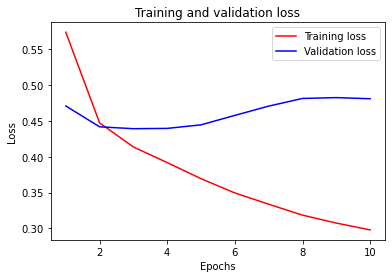

In [542]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

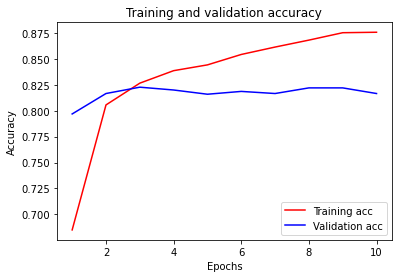

In [543]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()